# Everyone Eats - _A Food Illness Analysis_


## CMSC320 Final Project
### Authors: Andy Zhang, Michael Liu, Lucian Lum

<img src="files/Food-safety-infographic-thumbnail.jpg">

## Introduction

Everyone eats, especially when they travel! But just how safe is your food? This is a tutorial on some simple ways to collect and analyze data on food related illnesses across the United States (and territories). Afterwards, you will learn how to process the data and visualize it clearly. By analyzing the patterns, we will draw conclusions based on them. 

The goal of this tutorial is to show how often food related illnesses occur in each state and reveal the underlying trends.


## Getting Started

First, we need to download the datasets from the Centers for Disease Controll and Prevention (CDC) and the United States Census Bureau

Foodbourne Outbreak Online Database:
https://wwwn.cdc.gov/foodborneoutbreaks/

(The US Census has two separate tables)

US Census from 2000-2010
https://census.gov/data/tables/time-series/demo/popest/intercensal-2000-2010-state.html

Us Census from 2010-2016
https://www.census.gov/data/tables/2016/demo/popest/state-total.html#tables

These datasets will be in xlsx(excel) format. As a result, the first thing we need to do is convert the excel files to CSV (comma-separated values file). To do this, you just need to export the file into a CSV file and save it. (You don't have to convert it into a CSV file, we just prefer working with them).

Now that you have your CSV files, the next step is to load the file into a form that we can manipulate using python.

To do this we will use the pandas library.

For more information on Pandas, please check 'Closing and Sources'

<a id='toC'></a>

<b><font size="5" color="black">Table of Contents</font></b>
<ul type="1">
    <li><a href='#Installing_Libraries'>Installing Libraries</a></li>
    <li><a href='#load_data'>Loading and Organizing the Data</a></li>
    <li><a href='#etiology'>Etiology Status Analysis</a></li>
    <li><a href='#normal'>Normalizing the Data</a></li>
    <li><a href='#choropleth'>Choropleth Map</a></li>
    <li><a href='#conclusion'>Conclusion</a></li>
    <li><a href='#sources'>Closing and Sources</a></li>
</ul>


<a id='Installing_Libraries'></a>
## Installing Libraries

This project is written in Python 3, so make sure you have that installed

We will also use some basic python libraries:
<ul style="list-style-type:none">
  <ul style="list-style-type:circle">
      <li>pandas - \$ pip install pandas</li>
      <li>numpy - \$ pip install numpy</li>
      <li>folium - \$ pip install folium</li>
      <li>scikit-learn - \$ pip install scikit-learn</li>
  </ul>
</ul>

<font size="3"><a href='#toC'>To Table of Contents</a></font>

<a id='load_data'></a>
## Loading and Organizing the Data

In [478]:
import pandas as pd

# load the data into dataframes
# food illness data
food = pd.read_csv("FoodData.csv")
# 2000-2009 census data
table2000 = pd.read_csv("2000.csv")
# 2010-2016 census data
table2010 = pd.read_csv("2010.csv")

In [479]:
# remove data that we will not be using
# del food['Genus Species']
# del food['Etiology Status']
del food['Contaminated Ingredient']
del food['Serotype or Genotype']
del food['Food Vehicle']

# delete unnecessary areas
food = food[food.State != 'Multistate']
food = food[food.State != 'Republic of Palau']
food = food[food.State != 'Guam']

# since we are using the census since 2000, we will remove the data in years 1998 and 1999
food = food[food.Year != 1998]
food = food[food.Year != 1999]

# shows the stats of data before dropping rows with missing data
display(food.describe())

# drop rows with missing data
food = food.dropna(how='any')

# drop rows with inputs that isn't 'confirmed' or 'suspected'
food = food.loc[food['Etiology Status'].isin(['Confirmed','Suspected'])]
        
# organize the data by state, year, month
food = food.sort_values(['State','Year','Month'])

# shows the stats of data after dropping rows with missing data
display(food.describe())

,Year,Month,Illnesses,Hospitalizations,Deaths
count,16968.000000,16968.000000,16968.000000,14285.000000,14302.000000
mean,2007.114333,6.386728,18.437294,0.705495,0.012865
std,4.937221,3.453812,42.685308,2.467686,0.163785
min,2000.000000,1.000000,2.000000,0.000000,0.000000
25%,2003.000000,3.000000,3.000000,0.000000,0.000000
50%,2006.000000,6.000000,8.000000,0.000000,0.000000
75%,2011.000000,9.000000,19.000000,1.000000,0.000000
max,2016.000000,12.000000,1644.000000,71.000000,7.000000


,Year,Month,Illnesses,Hospitalizations,Deaths
count,9128.000000,9128.000000,9128.000000,9128.000000,9128.000000
mean,2008.005587,6.482143,21.157975,0.881135,0.014899
std,4.907501,3.430493,44.829898,2.833343,0.165494
min,2000.000000,1.000000,2.000000,0.000000,0.000000
25%,2004.000000,4.000000,4.000000,0.000000,0.000000
50%,2007.000000,6.000000,10.000000,0.000000,0.000000
75%,2013.000000,9.000000,22.000000,1.000000,0.000000
max,2016.000000,12.000000,1644.000000,71.000000,6.000000


The purpose of showing the details of the dataframe before and after dropping rows with missing data is to show that this action is justifiable.

We notice these changes in the data:
<ol type="1">
  <li>The mean years of the data increases after dropping the data
      <ul type="1">
          <li>The month is not as significant as the years</li>
      </ul></li>
  <li>The mean and standard deviation of illnesses increased</li>
  <li>The mean and standard deviation of hospitalizations incrased</li>
  <li>The mean of deaths increased, while the standard deviaion of deaths decreased</li>
</ol>

We believe that in the start of the 21rst century, data was not properly recorded compared to later years, resulting in a higher "year" average.

The changes in illnesses, hospitalizations, and deaths are small and not as significant

Based on these changes, we believe that taking out the rows in data with missing values is justifiable.

Since we have two dataframes of the US Census, we will need to merge them together.

In [480]:
# importing the regular expression library
import re

# took out the beginning and last few rows as they are irrelevant
table2000 = table2000.iloc[3:61]
# drop empty rows (there is one row that is completely empty)
table2000 = table2000.dropna(axis=0, how='all')

# drop unncessary columns
cols = [1,12,13]
table2000.drop(table2000.columns[cols], axis=1, inplace=True)

# rename column headers
table2000.columns = ['Region', '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']

# took out the beginning and last rows as they are irrelevant
table2010 = table2010.iloc[3:61]
# drop empty rows (there is one row that is completely empty)
table2010 = table2010.dropna(axis=0, how='all')

# drop unncessary columns
cols = [0,1,2]
table2010.drop(table2010.columns[cols], axis=1, inplace=True)

# rename column headers
table2010.columns = ['2010','2011','2012','2013','2014','2015','2016']

# merge the two dataframes together
population = table2000.join(table2010)

# the region column has a '.' in front of every state, this gets rid of it
# changes the District of Columbia to Washington DC to match the Food dataframe
for _, row in population.iterrows():
    row['Region'] = re.sub('[.]', '', row['Region'])
    if row['Region'] == 'District of Columbia':
        row['Region'] = re.sub('District of Columbia', 'Washington DC', row['Region'])
        

# reset the index for organization
population.reset_index()
population.head()

,Region,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
3,United States,"282,162,411","284,968,955","287,625,193","290,107,933","292,805,298","295,516,599","298,379,912","301,231,207","304,093,966","306,771,529","309,348,193","311,663,358","313,998,379","316,204,908","318,563,456","320,896,618","323,127,513"
4,Northeast,"53,666,295","53,915,522","54,143,915","54,334,453","54,423,533","54,451,230","54,522,659","54,653,362","54,875,926","55,133,101","55,388,056","55,632,766","55,829,059","55,988,771","56,116,791","56,184,737","56,209,510"
5,Midwest,"64,491,431","64,776,531","65,018,293","65,276,954","65,532,305","65,751,872","66,028,555","66,293,689","66,523,935","66,748,437","66,978,602","67,153,331","67,332,320","67,543,948","67,726,368","67,838,387","67,941,429"
6,South,"100,565,549","101,849,575","103,150,787","104,380,188","105,883,977","107,479,771","109,076,933","110,688,742","112,184,930","113,548,615","114,863,114","116,061,801","117,299,171","118,424,320","119,696,311","121,039,206","122,319,574"
7,West,"63,439,136","64,427,327","65,312,198","66,116,338","66,965,483","67,833,726","68,751,765","69,595,414","70,509,175","71,341,376","72,118,421","72,815,460","73,537,829","74,247,869","75,023,986","75,834,288","76,657,000"


<font size="3"><a href='#toC'>To Table of Contents</a></font>

<a id='etiology'></a>
## Etiology Status Analysis

In this section, we will analyze the column Etiology Status which has information on the status of cases, whether they were confirmed or suspected incidents of contamination.

In [481]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [482]:
# took out unncessary data, and normalize it
food["Etiology Status"].value_counts(normalize=True)


Confirmed    0.667507
Suspected    0.332493
Name: Etiology Status, dtype: float64

66.75% of all cases were confirmed while 33.25% of cases were suspected. 

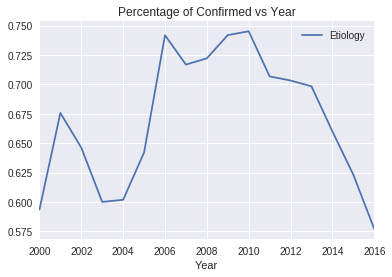

In [483]:
# sort by year then status
food_groupby = food[["Year","Etiology Status"]].groupby("Year")

year_list = []
percent = []

# create new dataframes to separate 'Confirmed' and 'Suspected' cases
for group in food["Year"].unique():
    
    df = food[food["Year"] == group]
    confirmed = df[df["Etiology Status"] == "Confirmed"]
    suspected = df[df["Etiology Status"] == "Suspected"]
    percent_confirm = len(confirmed)/len(df)
    percent.append(percent_confirm)
    year_list.append(group)
    
# create a graph showing percentage of confirmed vs year
year_vs_etiology = pd.DataFrame({'Year':year_list,'Etiology':percent})
year_vs_etiology = year_vs_etiology.sort_values(by='Year')
year_vs_etiology = year_vs_etiology.reset_index(drop=True)
year_vs_etiology.plot(x='Year',y='Etiology',title = 'Percentage of Confirmed vs Year')

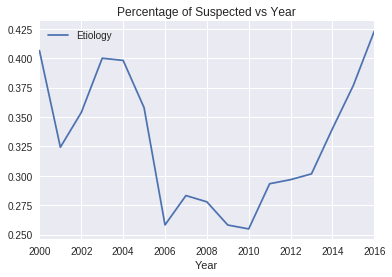

In [484]:
# similiar to the code above, but does the opposite
food_groupby = food[["Year","Etiology Status"]].groupby("Year")
year_list = []
percent = []

for group in food["Year"].unique():
    
    df = food[food["Year"] == group]
    confirmed = df[df["Etiology Status"] == "Confirmed"]
    suspected = df[df["Etiology Status"] == "Suspected"]
    percent_confirm = len(suspected)/len(df)
    percent.append(percent_confirm)
    year_list.append(group)
    
# creates a graph that will shows the reverse of the graph above, this shows percentage of suspected vs year
year_vs_etiology = pd.DataFrame({'Year':year_list,'Etiology':percent})
year_vs_etiology = year_vs_etiology.sort_values(by='Year')
year_vs_etiology = year_vs_etiology.reset_index(drop=True)
year_vs_etiology.plot(x='Year',y='Etiology',title='Percentage of Suspected vs Year')

From the data set provided to us, we are able to analyze the Etiology rates over time from the years 2000-2016. We discovered that in recent years, the number of confirmed illnesses dropped, and suspected illnesses increased. Now, lets pivot and focus our attention on the illnesses by state. The rest of this tutorial is dedicated towards analyzing and comparing these states over the years 2000-2016.

<font size="3"><a href='#toC'>To Table of Contents</a></font>

<a id='normal'></a>
## Normalizing the Data

In the next step, we are going to calculate the total number of incidents for each state, per year and per month. We will create an additional column at the end of our current dataframe named "Total Incidents". We decided to do this because we are not focusing on the severity of the illness, but are keeping track of the number of food illnesses.

In [485]:
# create a new column in dataframe, all values to 0
food['Total Incidents'] = '0.0'

# calculate the total number of incidents
for index,row in food.iterrows():
    food.ix[index, 'Total Incidents'] = food.ix[index, 'Illnesses'] + food.ix[index, 'Hospitalizations'] + food.ix[index,'Deaths']
    
food.head()

,Year,Month,State,Genus Species,Etiology Status,Location of Preparation,Illnesses,Hospitalizations,Deaths,Total Incidents
7927,2000,4,Alabama,Bacillus cereus,Suspected,Restaurant - other or unknown type,6,0.0,0.0,6
7914,2000,6,Alabama,Salmonella enterica,Confirmed,Restaurant - other or unknown type; Private ho...,40,1.0,0.0,41
7910,2000,8,Alabama,Salmonella enterica,Confirmed,Restaurant - other or unknown type,50,5.0,0.0,55
11682,2003,6,Alabama,Other - Chemical/Toxin,Suspected,Restaurant - other or unknown type,2,0.0,0.0,2
15902,2005,4,Alabama,Norovirus Genogroup I,Confirmed,Restaurant - other or unknown type,32,0.0,0.0,32


We decided to condense the data to each year instead of each month. This will make the data more readable. Additionally, this will help match the food dataframe to the population dataframe, as the US Census data shows the yearly estimates

In [486]:
from itertools import product

# orders the dataframe
states = food['State'].unique()
years = np.sort(food['Year'].unique())
df = pd.DataFrame(list(product(states, years)), columns=['State', 'Year'])
df['Total Incidents'] = 0

# organize the dataframe to show each state's total incidents for each year
for index,row in food.iterrows():
    state = food.ix[index, 'State']
    year = food.ix[index, 'Year']
    totalIncidents = food.ix[index, 'Total Incidents']
    df.loc[(df['State'] == state)  & (df['Year'] == year), 'Total Incidents'] += totalIncidents
    
# displays the first five rows
df.head()

,State,Year,Total Incidents
0,Alabama,2000,102.0
1,Alabama,2001,0.0
2,Alabama,2002,0.0
3,Alabama,2003,2.0
4,Alabama,2004,0.0


Using the table, we can create plots to look at how the total number of incidents changed between years for a specific state. For example, the graph below shows the change over time for the beautiful state of Maryland.

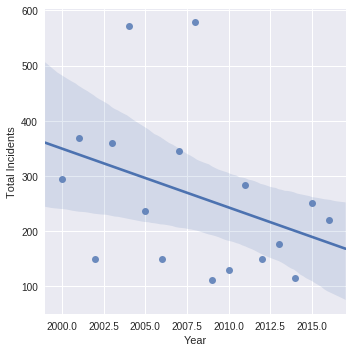

In [487]:
import seaborn as sns
maryland = df[df.State == 'Maryland']
sns.lmplot(x='Year', y='Total Incidents', data=maryland,fit_reg=True)

Now that we have the total number of incidents for each state, we can visualize the total number of incidents for each state and year right? Then we can start comparing the numbers to see which states is more likely to get food-related illness, and which states is safer. 

<b><big> WRONG!</big></b>

This data is meaningless without normalizing! For example, let's take California in 2002 and compare it to Washington DC in 2002.


In [488]:
display(df.loc[(df['State'] == 'California') & (df['Year'] == 2002)])
display(df.loc[(df['State'] == 'Washington DC') & (df['Year'] == 2002)])

,State,Year,Total Incidents
70,California,2002,1715.0


,State,Year,Total Incidents
818,Washington DC,2002,108.0


Wow! California had 1,715 incidents, while Washington DC only had 108 incidents! Does that mean you are around 16 times more likely to get sick in California than in Washington DC?

<b><big> NOPE!</big></b>


Intuitively, a state with a larger population would have more people consuming food/contracting food related illnesses. As of such, while California does have a lot more outbreaks than Washington DC, we have to remember that California has a larger population than Washington DC! Looking at the population table above, we see that California had a population of 34,871,843 in 2002, while Washingon DC only has 573,158. Using this information, we can normalize the total incidents and find the ratio of the population to number of incidents


In [489]:
# normalize the data
df['Total Incidents Normalized'] = 0
for index,row in df.iterrows():
    state = df.ix[index, 'State']
    year = df.ix[index, 'Year']
    totalIncidents = df.ix[index, 'Total Incidents']
    pop = population.loc[population['Region'] == state, str(year)]
    # tidying data from US census to make it an integer
    pop = str(pop).replace(',','')

    # utilizing regex to remove whitespace and unnecessary numbers
    pattern = re.compile('\d+\s+(\d+)')
    m =pattern.search(str(pop))
    pop = int(m.group(1))
    # normalizes the total incidents for the specific year and state
    if totalIncidents != 0:
        df.loc[(df['State'] == state)  & (df['Year'] == year), 'Total Incidents Normalized'] = int(pop)/int(totalIncidents)
        
# shows the first 5 results
df.head()

,State,Year,Total Incidents,Total Incidents Normalized
0,Alabama,2000,102.0,4.364875e+04
1,Alabama,2001,0.0,0.000000e+00
2,Alabama,2002,0.0,0.000000e+00
3,Alabama,2003,2.0,2.251746e+06
4,Alabama,2004,0.0,0.000000e+00


Now that our table is normalized, we have records of the total number of food related illnesses for each state in the years 2000 - 2016, as well as the normalized total. The normalized total can be interpreted as "For approximately every (Total Incidents Normaized) people living in (State) in the year (Year), there will be one serious food related illness". 

Let's compare California and Washington DC in 2002 again

In [490]:
display(df.loc[(df['State'] == 'California') & (df['Year'] == 2002)])
df.loc[(df['State'] == 'Washington DC') & (df['Year'] == 2002)]

,State,Year,Total Incidents,Total Incidents Normalized
70,California,2002,1715.0,20333.436152


,State,Year,Total Incidents,Total Incidents Normalized
818,Washington DC,2002,108.0,5307.018519


This shows that in California, one person will get sick in about every 20,000 people, and in Washington DC, one person will get sick in about every 5,000 people. You are 4 times more likely to get sick in Washington DC than in California!

Now, let's look at the total incidents for each year in the United States.

In [491]:
years = np.sort(food['Year'].unique())
total = pd.DataFrame(columns = ['Year', 'Total Incidents'])

total['Year'] = years
total['Total Incidents'] = 0
for index,row in df.iterrows():
    year = df.ix[index, 'Year']
    totalIncidents = df.ix[index, 'Total Incidents']
    total.loc[total['Year'] == year, 'Total Incidents'] += totalIncidents

total

,Year,Total Incidents
0,2000,11056.0
1,2001,14151.0
2,2002,15103.0
3,2003,12505.0
4,2004,18147.0
5,2005,11487.0
6,2006,17718.0
7,2007,12633.0
8,2008,14362.0
9,2009,7214.0


With our data set, we can also look at the total # of illnesses in the entire United States by year. Again however, it's important to consider population when analyzing our data, as the U.S. population continues to grow between the year 2000 - 2016.
We decided to normalize the data and look at the number of incidents per 100,000 people.

In [492]:
total['Total Incidents Per 100,000'] = 0
for index,row in total.iterrows():
    year = total.ix[index, 'Year']
    totalIncidents = total.ix[index, 'Total Incidents']
    pop = population.loc[population['Region'] == 'United States', str(year)]
    pop = str(pop).replace(',','') #tidying data from US census to make it an integer
    pattern = re.compile('\d+\s+(\d+)') #utilizing regex to remove whitespace and unnecessary numbers
    m =pattern.search(str(pop))
    pop = int(m.group(1))
    total.loc[total['Year'] == year, 'Total Incidents Per 100,000'] = totalIncidents/pop*100000
    
total

,Year,Total Incidents,"Total Incidents Per 100,000"
0,2000,11056.0,3.918311
1,2001,14151.0,4.965804
2,2002,15103.0,5.250931
3,2003,12505.0,4.310465
4,2004,18147.0,6.197634
5,2005,11487.0,3.887091
6,2006,17718.0,5.938067
7,2007,12633.0,4.193789
8,2008,14362.0,4.722882
9,2009,7214.0,2.351587


Our final table now shows the number of serious food related illnesses that occured for every 100,000 U.S. citizens for each year. We can analyze this further by taking a regression, using year as a time-series explanatory variable and Total Incidents Per 100,000 for our response. We will calculate the regression score for the plot to decide which model to use.

We can measure the accuracy of our regression by looking at the R^2 value for the linear model. We can first look at the accuracy of the regression between Year and Total Incidents.

In [493]:
from sklearn import linear_model
X = total['Year'].to_frame()
Y = total['Total Incidents']
reg = linear_model.LinearRegression()
reg.fit(X, Y)
reg.score(X, Y)

0.31428929013578777

The R^2 of .3143 shows that our explanatory variable is not very accurate when explaining the response. When we look at the regression comparing Year to Total Incidents per 100,000 citizens, it should be more accurate since we considered population growth.

In [494]:
X = total['Year'].to_frame()
Y = total['Total Incidents Per 100,000']
reg = linear_model.LinearRegression()
reg.fit(X, Y)
reg.score(X, Y)

0.42467046609126297

The new R^2 of .4247 is still not very accurate, but is much better than our previous score of .2848. Although imperfect, this means that our regression improved once we took into account population within our data. We will use this model for our graph.

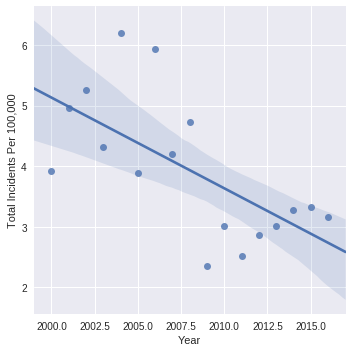

In [495]:
sns.lmplot(x='Year', y='Total Incidents Per 100,000',data=total,fit_reg=True)

We can see a general trend in the graph. The number of food related illnesses in the United States is slowly decreasing. Advances in technology as well as food safety regulations are the likely cause of this. New laws are being made to promote citizen welfare. Outbreaks such as Chipotle's 2008 food scare also showed that a company's food poisoning incidents would lead to loss of customers and investors. Companies likely became more stricter when it came to food sanitation after these events.

Now, let's look at each state and compare the # of incidents over time.

In [496]:
states = np.sort(food['State'].unique())
total_by_state = pd.DataFrame(columns = ['State', 'Total Incidents'])
total_by_state['State'] = states
total_by_state['Total Incidents'] = 0
for index,row in df.iterrows():
    s = df.ix[index, 'State']
    totalIncidents = df.ix[index, 'Total Incidents']
    total_by_state.loc[total_by_state['State'] == s, 'Total Incidents'] += totalIncidents

total_by_state = total_by_state.sort_values(['Total Incidents'])
total_by_state

,State,Total Incidents
7,Delaware,126.0
25,Montana,201.0
45,Vermont,241.0
48,Washington DC,286.0
26,Nebraska,366.0
38,Puerto Rico,381.0
49,West Virginia,436.0
41,South Dakota,595.0
18,Maine,618.0
39,Rhode Island,621.0


Again, we need to normalize our data and account for state population.

In [497]:
total_by_state['Total Incidents Normalized'] = 0
for index,row in df.iterrows():
    s = df.ix[index, 'State']
    totalIncidentsNorm = df.ix[index, 'Total Incidents Normalized']
    total_by_state.loc[total_by_state['State'] == s, 'Total Incidents Normalized'] += totalIncidentsNorm

total_by_state = total_by_state.sort_values(['Total Incidents Normalized'])
total_by_state.head()

,State,Total Incidents,Total Incidents Normalized
48,Washington DC,286.0,73096.412996
22,Minnesota,12038.0,136428.160215
25,Montana,201.0,235974.387540
50,Wisconsin,7918.0,261860.269083
36,Oregon,6276.0,273273.353067


We sorted the table by the normalized number of incidents, which is interpreted as "There will be one serious food related illness for every X population". We can see from the graph that Washington DC had the least safe food conditions with an illness occurring for every 81,388 residents. Indiana on the other hand, had the best conditions with an illness only occurring for every 4,161,087 residents.

<font size="3"><a href='#toC'>To Table of Contents</a></font>

<a id='choropleth'></a>
## Choropleth Map

After compiling the total incidents per state, we sought to visualize our data with a Choropleth, which allowed us to see which states had the highest amount of incidents.

In [498]:
#isolating incidents to the most recent year
most_recent_year_df = df[df['Year'] == 2016]
#choosing the fields that are most relevant to the choropleth
most_recent_year_df = most_recent_year_df[['State','Total Incidents Normalized','Total Incidents']]
most_recent_year_list = most_recent_year_df.values.tolist()

#Setting names to each of the columns
most_recent_year_df.columns = ['name','total','Total Incidents']
most_recent_year_df.head()

,name,total,Total Incidents
16,Alabama,14474.107143,336.0
33,Alaska,19022.923077,39.0
50,Arizona,68624.465347,101.0
67,Arkansas,0.000000,0.0
84,California,52543.530120,747.0



<b><font size="5" color="black">Folium Map</font></b>
<ol type="1">
    <li>Imported a GeoJSON file that outlined the boundaries of each of the United States</li>
    <li>Imported a GeoJSON file that had a record of each state's latitude and longitude values for each marker to be placed</li>
    <li>Parsed each relevant GeoJSON file and plotted a Choropleth using Folium</li>
    <li>Plotted each state's marker and added pertaining information such as total incidents per state.</li>

</ol>

In [499]:
import folium
import json
from folium.features import CustomIcon
map_osm = folium.Map(location=[39.8283, -98.5795],zoom_start = 4.25)

#importing each of the GEOjson files
all_states = json.load(open('us-states.json'))
lat_long = pd.read_json(open('USstates_avg_latlong.json'))
#img = Image.open('ramen.png')
#url = 'https://chochosansushi.files.wordpress.com/2016/02/{}'.format
#icon_image = url('miso-ramen-no-background.png')
#shadow_image = url('leaf-shadow.png')



#iterating over each state
for state in most_recent_year_df['name'].unique():
    #extracting the latitude and longitutde of each state
    lat = lat_long[lat_long['state'] == state]['latitude']
    lon = lat_long[lat_long['state'] == state]['longitude']
    #excludes puerto rico due to lack of data
    if(len(lat) != 0):
        #adding a custom icon to each marker
        url = 'http://www.asahicom.jp/special/tsukiji/images/tuna-prologue/{}'.format
        icon_image = url('kuromaguro.png')

        icon = CustomIcon(
        icon_image,
        icon_size=(38, 95),
        icon_anchor=(22, 94),
        #shadow_image=shadow_image,
        #shadow_size=(50, 64),
        #shadow_anchor=(4, 62),
        #popup_anchor=(-3, -76)
        )
        #calculating the total number of incidents in that state in 2016
        total = ((df.loc[(df['State'] == state)  & (df['Year'] == 2016), 'Total Incidents']).values[0])
        popup = '<i>'+str(state)+'</i>' + '<br>Total Incidents: '+str(total)+'</br>'
        #plotting the marker
        marker =  folium.Marker(location = [lat.values[0],lon.values[0]],icon=icon,popup=popup)
        map_osm.add_child(marker)    
        
#plotting the choorpleth
map_osm.choropleth(
    geo_data =all_states,
    data = most_recent_year_df,name='choropleth',key_on = 'feature.properties.name',
    columns = ['name', 'Total Incidents'],fill_color = 'YlGn',
    legend_name ="Number of Incidents in 2016 (Normalized to 100,000 people)"
)

#displaying
folium.LayerControl().add_to(map_osm)
map_osm

<font size="3"><a href='#toC'>To Table of Contents</a></font>

<a id='conclusion'></a>
## Conclusion

We sorted the table by the normalized number of incidents, which is interpreted as "There will be one serious food related illness for every X population". We can see from the graph that Washington DC had the least safe food conditions with an illness occurring for every 81,388 residents. Texax on the other hand, had the best conditions with an illness only occurring for every 4,393,464 residents.

According to our data, the five areas with the highest chance of food poisoning are Washington D.C., Minnesota, Montana, Wisconsin, and Oregon. The five areas with the lowest chance are Indiana, Texas, North Carolina, Alabama, and Missouri. This is based off the number of incidents that have occurred between 2000 to 2016, and is normalized with population data from the census from this time period as well. If you're a germaphobe that happens to be a foodie, you should be extra cautious when eating in states with a high likelihood of food poisoning. It's also important to note that this set of data is taken from a specific time range. Changes in food safety regulations in the future will impact the reliability of our data set. In general, food poisoning incidents have been decreasing over time according to our regression model. In recent years our model estimates that only 3 out of 100,000 citizens contract a serious illness from eating food. So in the end, you really don't need be that concerned when eating a dish at your favorite restaurant. Still, the CDC estimates that approximately 48 million people get sick as a result of foodborne illnesses each year. Our data likely doesn't record less serious incidents where infected individuals don't report to a hospital. You are also still likely to contract a disease from interacting with infected individuals or food ingredients without eating them. Remember to wash your hands and always be safe 😀

<font size="3"><a href='#toC'>To Table of Contents</a></font>

<a id='sources'></a>
## Closing & Sources

Thank you for reading our tutorial! This tutorial covers basic ways to interact with data and present findings in multiple ways. There are many reasons that can explain the health changes, and even more ways to present your findings.

If you would like to do more research below and try it out yourself, these links will help!

<ul type="1">
    <li><a href='https://en.wikipedia.org/wiki/Disease_burden'>Disease burden</a></li>
    <li><a href='http://www.businessinsider.com/food-poisoning-expert-on-why-chipotles-dealing-with-nightmare-2017-7'>Chipotle Scandal</a></li>
    <li><a href='https://en.wikipedia.org/wiki/List_of_foodborne_illness_outbreaks_in_the_United_States'>List of Foodborne Illness Outbreaks</a></li>
    <li><a href='https://www.cdc.gov/winnablebattles/foodsafety/pdf/Trends_in_Foodborne_Illness.pdf'>Trends in Foodborne Illness</a></li>
    <li><a href='https://github.com/python-visualization/folium'>Folium</a></li>
    <li><a href='http://scikit-learn.org/stable/tutorial/basic/tutorial.html'>Scikit-learn</a></li>
    <li><a href='http://pandas.pydata.org/pandas-docs/stable/'>Pandas</a></li>
    <li><a href='https://matplotlib.org/api/pyplot_summary.html#the-pyplot-api'>Matplotlib</a></li>
</ul>


<font size="3"><a href='#toC'>To Table of Contents</a></font>